In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import json
from uncertainties import ufloat
import glob
import pandas
import json

import mplhep
mplhep.style.use(mplhep.style.CMS)

import sys
sys.path.append("../../mlpf/")
from plotting.plot_utils import pid_to_text, format_dataset_name

In [5]:
!mkdir plots_mlpf_clic_2023

In [ ]:
def get_combined_array(histories, key):
    combined_array = np.array(histories[0][key])
    for ii in range(1, len(histories)):
        combined_array = np.vstack([combined_array, np.array(histories[ii][key])])
    return combined_array


def get_full_history(hist_dir, verbose=False):
    jsons = list(hist_dir.glob("history*.json"))
    if verbose:
        print(f"{hist_dir.parent} has {len(jsons)} hisotries")
    if len(jsons) == 0:
        return {}, 0
    jsons.sort(key=lambda x: int(x.name.split("_")[1].split(".")[0]))  # sort according to epoch number

    # initialize a dict with correct keys and empty lists as values
    with open(jsons[0]) as h:
        keys = json.load(h).keys()
    full_history = {key: [] for key in keys}

    # join epoch values to a full history
    for path in jsons:
        with open(path) as h:
            epoch = json.load(h)
            for key in epoch.keys():
                full_history[key].append(epoch[key])

    reg_loss = np.sum(
        np.array([full_history["{}_loss".format(l)] for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]]),
        axis=0,
    )
    val_reg_loss = np.sum(
        np.array(
            [full_history["val_{}_loss".format(l)] for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]]
        ),
        axis=0,
    )
    full_history.update({"reg_loss": reg_loss})
    full_history.update({"val_reg_loss": val_reg_loss})

    return full_history, len(jsons)


def get_histories(train_dirs):
    train_dirs = [Path(train_dir) for train_dir in train_dirs]
    histories = []

    for train_dir in train_dirs:
        hist, N = get_full_history(hist_dir=train_dir / "logs/history")
        if N > 0:
            histories.append(hist)

    return histories

In [ ]:
histories_gnn_before = get_histories(list(glob.glob("../../models/mlpf-clic-2023-results/hypertuning/clic_gnn_beforeHPO/*")))
histories_gnn_after = get_histories(list(glob.glob("../../models/mlpf-clic-2023-results/hypertuning//clic_gnn_afterHPO/*")))

histories_tf_before = get_histories(list(glob.glob("../../models/mlpf-clic-2023-results/hypertuning//clic_transformer_beforeHPO/*")))
histories_tf_after = get_histories(list(glob.glob("../../models/mlpf-clic-2023-results/hypertuning//clic_transformer_afterHPO/*")))

In [ ]:
ret = {
    "gnn": {
        "before": {
            "val_loss": get_combined_array(histories_gnn_before,"val_loss"),
            "jet_iqr": get_combined_array(histories_gnn_before,"val_jet_iqr"),
            "met_iqr": get_combined_array(histories_gnn_before,"val_met_iqr"),
        },
        "after": {
            "val_loss": get_combined_array(histories_gnn_after,"val_loss"),
            "jet_iqr": get_combined_array(histories_gnn_after,"val_jet_iqr"),
            "met_iqr": get_combined_array(histories_gnn_after,"val_met_iqr"),
        }
    },
    "transformer": {
        "before": {
            "val_loss": get_combined_array(histories_tf_before,"val_loss"),
            "jet_iqr": get_combined_array(histories_tf_before,"val_jet_iqr"),
            "met_iqr": get_combined_array(histories_tf_before,"val_met_iqr"),
        },
        "after": {
            "val_loss": get_combined_array(histories_tf_after,"val_loss"),
            "jet_iqr": get_combined_array(histories_tf_after,"val_jet_iqr"),
            "met_iqr": get_combined_array(histories_tf_after,"val_met_iqr"),
        }
    }
}

In [ ]:
def sigdigits(mean, std):
    return "{:L}".format(ufloat(mean, std))


def run_label(x=0.67, y=0.90, fz=12):
    plt.figtext(x, y, r'tt+qq',  wrap=False, horizontalalignment='right', fontsize=fz)


def cms_label(x0=0.12, y=0.90, s=None, fz=22):
    # plt.figtext(x0, y,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=fz)
    # plt.figtext(x0+0.09, y,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=fz-3)
    if s is not None:
        t = plt.figtext(x=x0, y=y-0.15, s=s[:-1], fontsize=fz-6)


def plot_variance_curve(array_list,
                        labels,
                        colors_styles,
                        skip=0,
                        ylim=None,
                        save_path=None,
                        x=0.45,
                        y=0.53,
                        loc=None,
                        ylabel=None,
                        custom_info=None,
                        threshold=None
                       ):
    
    fig = plt.figure()
    final_means = []
    final_stds = []
    for ii, array in enumerate(array_list):
        print(f"{labels[ii]} is averaged over {array.shape[0]} trainings.")
        xx = np.array(range(array.shape[1])) + 1  # Epochs

        xx = xx[skip:]
        array = array[:, skip:]

        std = np.std(array, axis=0)
        mean = np.mean(array, axis=0)

        col, sty = colors_styles[ii]
        plt.plot(xx, mean, label=labels[ii], color=col, ls=sty)
        plt.fill_between(xx, mean - std, mean + std, alpha=0.4, facecolor=col)

        # Add individual loss curves
        # plt.plot(np.tile(xx, reps=[10,1]).transpose(), array.transpose(), linewidth=0.2)

        print(labels[ii] + ": {:s}".format(sigdigits(mean[-1], std[-1])))
        final_means.append(mean[-1])
        final_stds.append(std[-1])

    if threshold:
        plt.axhline(threshold, ls="--", color="black", label="baseline PF")    
        
#     plt.legend(bbox_to_anchor=(0.98, 0.78), loc="center right")
    legtitle = r"$\mathrm{t}\overline{\mathrm{t}}, \gamma/\mathrm{Z}^* \rightarrow \mathrm{hadrons}$"
    if loc is not None:
        plt.legend(loc=loc, title=legtitle)
    else:
        plt.legend(title=legtitle)
    plt.xlabel("Epochs")
    if ylabel:
        plt.ylabel(ylabel)

    s="Mean and stddev of {:d} trainings\n".format(array.shape[0])
    for ii, label in enumerate(labels):
        if custom_info:
            s += "Final {}: ${:s}$\n".format(label, sigdigits(custom_info[ii]['mean'], custom_info[ii]["std"]))
        else:
            s += "Final {}: ${:s}$\n".format(label, sigdigits(final_means[ii], final_stds[ii]))

    if ylim:
        plt.ylim(top=ylim[1], bottom=ylim[0])

    # plt.subplots_adjust(left=0.14)
    
    cms_label(x0=x, y=y, s=s, fz=24)
    # run_label(x=0.9, y=0.89, fz=22)
    if save_path:
        plt.savefig(Path(save_path).with_suffix('.png'))
        plt.savefig(Path(save_path).with_suffix('.pdf'))
    plt.show()

## Figure 4: hypertuning

In [ ]:
plot_variance_curve([ret["gnn"]["before"]["val_loss"], ret["gnn"]["after"]["val_loss"],
                     ret["transformer"]["before"]["val_loss"], ret["transformer"]["after"]["val_loss"]],
                    ["GNN", "GNN-HPO","TF", "TF-HPO"],
                    [("red", "--"), ("red", "-"), ("blue", "--"), ("blue", "-")],
                    skip=1,
                    ylim=[0, 20],
                    save_path="plots_mlpf_clic_2023/loss.png",
                    x=0.20,
                    y=0.85,
                    ylabel="Total validation loss (a.u.)"
                   )

In [ ]:
plot_variance_curve([ret["gnn"]["before"]["jet_iqr"], ret["gnn"]["after"]["jet_iqr"],
                     ret["transformer"]["before"]["jet_iqr"], ret["transformer"]["after"]["jet_iqr"]],
                    ["GNN", "GNN-HPO","TF", "TF-HPO"],
                    [("red", "--"), ("red", "-"), ("blue", "--"), ("blue", "-")],
                    skip=1,
                    save_path="plots_mlpf_clic_2023/jet_iqr.png",
                    x=0.20,
                    y=0.85,
                    ylim=(0, 0.3),
                    ylabel=r"jet response IQR")

In [ ]:
plot_variance_curve([ret["gnn"]["before"]["met_iqr"], ret["gnn"]["after"]["met_iqr"],
                     ret["transformer"]["before"]["met_iqr"], ret["transformer"]["after"]["met_iqr"]],
                    ["GNN", "GNN-HPO","TF", "TF-HPO"],
                    [("red", "--"), ("red", "-"), ("blue", "--"), ("blue", "-")],
                    skip=1,
                    save_path="plots_mlpf_clic_2023/met_iqr.png",
                    x=0.2,
                    y=0.85,
                    ylim=(0, 2),
                    ylabel=r"MET response IQR"
                   )

## Figure 5: scaling of inference timing with number of inputs

In [ ]:
timing_data_gpu_1 = open("../../models/clic2023_20230802/timing/mlpf-gnn/gpu_timing_1.txt").read()
timing_data_gpu_2 = open("../../models/clic2023_20230802/timing/mlpf-gnn/gpu_timing_2.txt").read()
timing_data_gpu_3 = open("../../models/clic2023_20230802/timing/mlpf-gnn/gpu_timing_2.txt").read()

In [ ]:
batches = []
nptcls = []
ts = []

for line in timing_data_gpu_1.strip().split("\n") + timing_data_gpu_2.strip().split("\n") + timing_data_gpu_3.strip().split("\n"):
    batch, nptcl, t = line.split()
    batches.append(int(batch))
    nptcls.append(int(nptcl))
    ts.append(float(t))
    
df = pandas.DataFrame()
df["batch"] = batches
df["nptcl"] = nptcls
df["t"] = ts

In [ ]:
df_agg = df.groupby(['batch', 'nptcl'], as_index=False).agg({'t':['mean','std']})

In [ ]:
sf = df_agg[(df_agg["batch"]==16) & (df_agg["nptcl"]==256)]["t"]["mean"].values[0]/16

plt.plot([256,20*256], [1,20], color="black", ls="--", lw=2, label="linear scaling")

markers = ["o", "^", "v", "s", "."]
for batch, elem in df_agg.groupby("batch"):
    m = markers.pop(0)
    plt.errorbar(
        elem["nptcl"],
        elem["t"]["mean"]/sf/batch,
        elem["t"]["std"]/sf/batch,
        label="B={}".format(batch),
        marker=m)
plt.legend(loc="best")
plt.ylabel("Relative time per event\nT(N,B) / T(256,16)")
plt.xlabel("Input elements per event, N")
plt.savefig("plots_mlpf_clic_2023/mlpf_gnn.png")
plt.savefig("plots_mlpf_clic_2023/mlpf_gnn.pdf")
plt.show()


In [26]:
#cd experiments-archive/timing/pandora
#grep TIMER gun_np* | grep MyDDMarlinPandora

timing_data_cpu = """
gun_np_100_1.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            | 12257.000 | 12258.470 | 8266.205   15065.3  2243.62 |      10 |   122.585 |
gun_np_100_2.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            | 12584.000 | 12586.436 | 9306.140   16603.8  2254.28 |      10 |   125.864 |
gun_np_100_3.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            | 13469.000 | 13469.058 | 10559.396   19125.7  2767.47 |      10 |   134.691 |
gun_np_200_1.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            | 49543.000 | 49544.113 | 42125.613   66414.5  7608.42 |      10 |   495.441 |
gun_np_200_2.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            | 48916.000 | 48917.770 | 40950.480   55557.2  4728.46 |      10 |   489.178 |
gun_np_200_3.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            | 48926.000 | 48925.219 | 42309.555   58747.8  4478.12 |      10 |   489.252 |
gun_np_25_1.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            |  1589.000 |  1589.525 |  984.285    2906.3   572.88 |      10 |    15.895 |
gun_np_25_2.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            |  1586.000 |  1582.584 | 1205.349    2140.1   308.66 |      10 |    15.826 |
gun_np_25_3.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            |  1769.000 |  1771.345 | 1069.436    2687.1   663.88 |      10 |    17.713 |
gun_np_50_1.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            |  4398.000 |  4400.301 | 2351.540    6855.1  1404.28 |      10 |    44.003 |
gun_np_50_2.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            |  4192.000 |  4190.113 | 2748.873    5741.2  1020.65 |      10 |    41.901 |
gun_np_50_3.txt:TIMER.TIMER          INFO  MyDDMarlinPandora            |  4172.000 |  4173.470 | 3003.761    5711.3   834.70 |      10 |    41.735 |
"""

timing_data = {}
for line in timing_data_cpu.strip().split("\n"):
    lspl = line.split()
    nptcl = int(lspl[0].split(":")[0].split("_")[2])
    dt = float(lspl[4])
    if not (nptcl in timing_data):
        timing_data[nptcl] = []
    timing_data[nptcl].append(dt)


timing_data_mem_raw = """
gun_np_100_1.txt:       Maximum resident set size (kbytes): 4200616
gun_np_100_2.txt:       Maximum resident set size (kbytes): 4300108
gun_np_100_3.txt:       Maximum resident set size (kbytes): 4216444
gun_np_200_1.txt:       Maximum resident set size (kbytes): 7683184
gun_np_200_2.txt:       Maximum resident set size (kbytes): 7648704
gun_np_200_3.txt:       Maximum resident set size (kbytes): 7599044
gun_np_25_1.txt:        Maximum resident set size (kbytes): 1953052
gun_np_25_2.txt:        Maximum resident set size (kbytes): 2089588
gun_np_25_3.txt:        Maximum resident set size (kbytes): 2045860
gun_np_50_1.txt:        Maximum resident set size (kbytes): 2637660
gun_np_50_2.txt:        Maximum resident set size (kbytes): 2808484
gun_np_50_3.txt:        Maximum resident set size (kbytes): 2699452
"""

timing_data_mem = {}
for line in timing_data_mem_raw.strip().split("\n"):
    lspl = line.split()
    nptcl = int(lspl[0].split(":")[0].split("_")[2])
    rss = float(lspl[6])
    print(rss)
    if not (nptcl in timing_data_mem):
        timing_data_mem[nptcl] = []
    timing_data_mem[nptcl].append(rss)

4200616.0
4300108.0
4216444.0
7683184.0
7648704.0
7599044.0
1953052.0
2089588.0
2045860.0
2637660.0
2808484.0
2699452.0


In [25]:
timing_data_mem

{100: [4200616.0, 4300108.0, 4216444.0],
 200: [7683184.0, 7648704.0, 7599044.0],
 25: [1953052.0, 2089588.0, 2045860.0],
 50: [2637660.0, 2808484.0, 2699452.0]}

In [27]:
means = []
stds = []
xs = []
for k in sorted(timing_data.keys()):
    means.append(np.mean(timing_data[k]))
    stds.append(np.std(timing_data[k]))
    xs.append(k)
xs = np.array(xs)
means = np.array(means)
stds = np.array(stds)


means_mem = []
stds_mem = []
xs_mem = []
for k in sorted(timing_data_mem.keys()):
    means_mem.append(np.mean(timing_data_mem[k]))
    stds_mem.append(np.std(timing_data_mem[k]))
    xs_mem.append(k)
xs_mem = np.array(xs_mem)
means_mem = np.array(means_mem)
stds_mem = np.array(stds_mem)

In [28]:
means_mem[0]

2029500.0

Text(1, 0, '$\\pi^-$ particles per event, $N$')

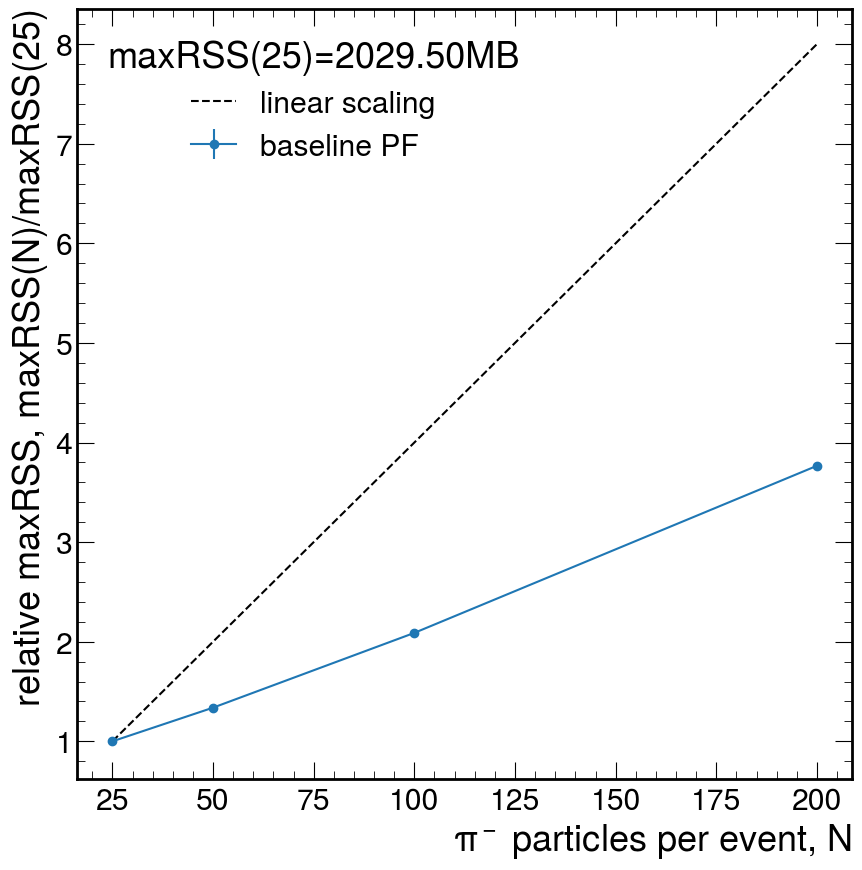

In [29]:
plt.errorbar(xs_mem, means_mem/means_mem[0], stds_mem/means_mem[0], marker="o", label="baseline PF")
plt.plot([25,200], [1,8], color="black", label="linear scaling", ls="--")
plt.legend(title="maxRSS(25)={:.2f}MB".format(means_mem[0]/1000))
plt.ylabel("relative maxRSS, $maxRSS(N)/maxRSS(25)$")
plt.xlabel("$\pi^-$ particles per event, $N$")

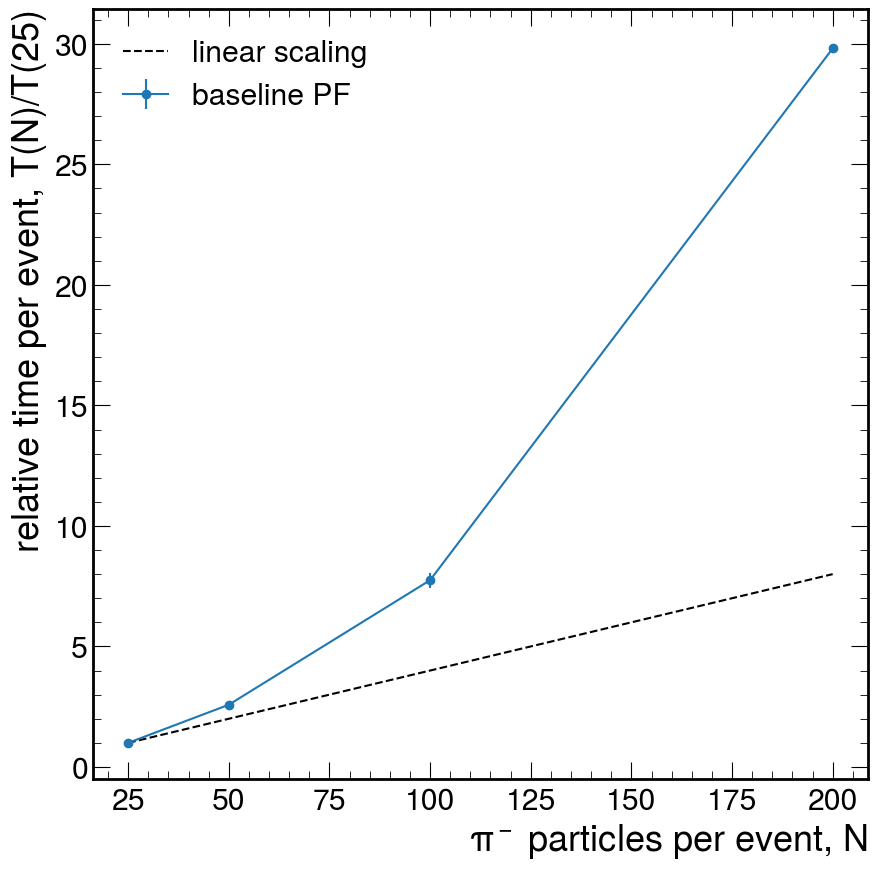

In [11]:
plt.errorbar(xs, means/means[0], stds/means[0], marker="o", label="baseline PF")
plt.plot([25,200], [1,8], color="black", label="linear scaling", ls="--")
plt.legend()
plt.ylabel("relative time per event, $T(N)/T(25)$")
plt.xlabel("$\pi^-$ particles per event, $N$")
#plt.xlim(0,100)
#plt.ylim(0,10)
plt.savefig("plots_mlpf_clic_2023/baseline_pf.png")
plt.savefig("plots_mlpf_clic_2023/baseline_pf.pdf")
plt.show()

In [ ]:
throughput_gpu = sf

num_tracks_clusters_pi100 = np.array([[93 , 182],
[95 , 200],
[93 , 191],
[96 , 127],
[95 , 153],
[98 , 166],
[98 , 151],
[104, 158],
[97 , 156],
[93 , 175]])


throughput_cpu = (means[2]/1000/10)

print(throughput_cpu, throughput_gpu)
print(num_tracks_clusters_pi100.mean(axis=0))
print(num_tracks_clusters_pi100.std(axis=0))

## Figure 6: jet and MET IQR for the hit-based training

In [ ]:
hists = sorted(list(glob.glob("../../models/clic2023_20230802/hits/clic-hits-ln_*/logs/history/*")))

In [ ]:
loss_vals = []
val_loss_vals = []

for hist in hists:
    loss_vals.append(json.load(open(hist))["loss"])
    val_loss_vals.append(json.load(open(hist))["val_loss"])

loss_vals = np.array(loss_vals)
val_loss_vals = np.array(val_loss_vals)

plt.plot(loss_vals, label="train loss", color="black", ls="--", marker="s")
plt.plot(val_loss_vals, label="val loss", color="black", marker="o")

plt.legend(title=format_dataset_name("clic_edm_ttbar_pf"))
plt.ylim(0,0.4)
plt.xlim(0, 22)
plt.ylabel("Validation loss")
plt.xlabel("Training epoch")
#plt.title("Training on tracks and calorimeter hits")
#plt.savefig("plots_mlpf_clic_2023/hitbased_res_iqr.png")
#plt.savefig("plots_mlpf_clic_2023/hitbased_res_iqr.pdf")
plt.show()

In [ ]:
jet_iqr_vals = []
met_iqr_vals = []

xvals = np.arange(1,11)
for hist in hists:
    jet_iqr_vals.append(json.load(open(hist))["val_jet_iqr"])
    met_iqr_vals.append(json.load(open(hist))["val_met_iqr"])

jet_iqr_vals = np.array(jet_iqr_vals)
met_iqr_vals = np.array(met_iqr_vals)

plt.plot(xvals, jet_iqr_vals, label="jet response IQR", marker="o")
plt.plot(xvals, met_iqr_vals/5, label="MET response IQR / 5", marker="o")
plt.legend(title=format_dataset_name("clic_edm_ttbar_pf"))
plt.ylim(0,0.2)
plt.xlim(1, 10)
plt.ylabel("Response IQR (a.u.)")
plt.xlabel("Training epoch")
#plt.title("Training on tracks and calorimeter hits")
plt.savefig("plots_mlpf_clic_2023/hitbased_res_iqr.png")
plt.savefig("plots_mlpf_clic_2023/hitbased_res_iqr.pdf")
plt.show()

In [ ]:
jet_med_vals = []
met_med_vals = []

for hist in hists:
    jet_med_vals.append(json.load(open(hist))["val_jet_med"])
    met_med_vals.append(json.load(open(hist))["val_met_med"])

jet_med_vals = np.array(jet_med_vals)
met_med_vals = np.array(met_med_vals)

plt.plot(jet_med_vals, label="jet response median", marker="o")
plt.plot(met_med_vals, label="MET response median", marker="o")
plt.legend(title=format_dataset_name("clic_edm_ttbar_pf"))
plt.axhline(1.0, color="black", ls="--")
plt.ylim(0.8,1.2)
#plt.xlim(0, 12)

plt.ylabel("Response median (a.u.)")
plt.xlabel("Training epoch")
#plt.title("Training on tracks and calorimeter hits")
plt.savefig("plots_mlpf_clic_2023/hitbased_res_med.png")
plt.savefig("plots_mlpf_clic_2023/hitbased_res_med.pdf")
plt.show()

## Scaling with a varying number of GPUs

In [ ]:
def import_scale_test(path="../../models/mlpf-clic-2023-results/gpu_scaling/scale_test_gnn_h100/scale_testV3_*/result.json"):
    num_gpus = []
    epoch_times = []
    epoch_times_std = []
    horovod_enabled = []
    df = pandas.DataFrame()
    for fn in glob.glob(path):
        data = json.load(open(fn))
        epoch_times.append(np.mean(data["wl-stats"]["epoch_times"][1:]))
        epoch_times_std.append(np.std(data["wl-stats"]["epoch_times"][1:]))
        num_gpus.append(data["wl-stats"]["GPU"])
        horovod_enabled.append(data["wl-stats"].get("horovod_enabled", False))

    df["num_gpus"] = num_gpus
    df["epoch_times"] = epoch_times
    df["epoch_times_std"] = epoch_times_std
    df["horovod_enabled"] = horovod_enabled
    df = df.sort_values("num_gpus")
    return df

In [ ]:
df_h100 = import_scale_test("../../models/mlpf-clic-2023-results/gpu_scaling/scale_test_gnn_h100/*/result.json")
df_mi250x = import_scale_test("../../models/mlpf-clic-2023-results/gpu_scaling/scale_test_gnn_mi250x/*/result.json")
df_hpu = import_scale_test("../../models/mlpf-clic-2023-results/gpu_scaling/scale_test_gnn_gaudi/*/result.json")
df_hpu2 = import_scale_test("../../models/mlpf-clic-2023-results/gpu_scaling/scale_test_gnn_gaudi2/*/result.json")

In [ ]:
plt.plot([1,8],[1,8], color="black", ls="--", label="linear scaling")
plt.plot(
    df_h100["num_gpus"].values,
    df_h100["epoch_times"].values[0]/df_h100["epoch_times"].values,
    marker="o", label="CoreSite (H100)")
plt.plot(
    df_mi250x["num_gpus"].values,
    df_mi250x["epoch_times"].values[0]/df_mi250x["epoch_times"].values,
    marker="s", label="LUMI (MI250X)")
plt.plot(
    df_hpu["num_gpus"].values,
    df_hpu["epoch_times"].values[0]/df_hpu["epoch_times"].values,
    marker="s", label="Voyager (Gaudi1)")
plt.plot(
    df_hpu2["num_gpus"].values,
    df_hpu2["epoch_times"].values[0]/df_hpu2["epoch_times"].values,
    marker="s", label="Voyager (Gaudi2)")
plt.legend(loc="best")
plt.xlabel("Accelerator processors, N")
plt.ylabel("Speedup over single accelerator, T(1)/T(N)")
plt.savefig("./plots_mlpf_clic_2023/scale_test.pdf")
plt.savefig("./plots_mlpf_clic_2023/scale_test.png")

In [ ]:
plt.plot(
    df_h100["num_gpus"].values,
    df_h100["epoch_times"].values,
    marker="o", label="CoreSite (H100)")
plt.plot(
    df_mi250x["num_gpus"].values,
    df_mi250x["epoch_times"].values,
    marker="s", label="LUMI (MI250X)")
plt.plot(
    df_hpu["num_gpus"].values,
    df_hpu["epoch_times"].values,
    marker="s", label="Voyager (Gaudi1)")
plt.plot(
    df_hpu2["num_gpus"].values,
    df_hpu2["epoch_times"].values,
    marker="s", label="Voyager (Gaudi2)")
plt.legend(loc="best")
plt.xlabel("Accelerator processors, N")
plt.ylabel("time per epoch, T(N) [s]")